In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 14 07:36:50 2022

@author: Paul Vincent Nonat
"""


import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt
import os
import argparse
from sklearn.model_selection import train_test_split 
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,matthews_corrcoef

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import seaborn as sns

In [2]:
transactions = pd.read_csv("../data/transactions_train.csv")
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


#### Correlation Matrix on Balanced Dataset

Distribution of the classes in the Balanced dataset
0    0.5
1    0.5
Name: isFraud, dtype: float64


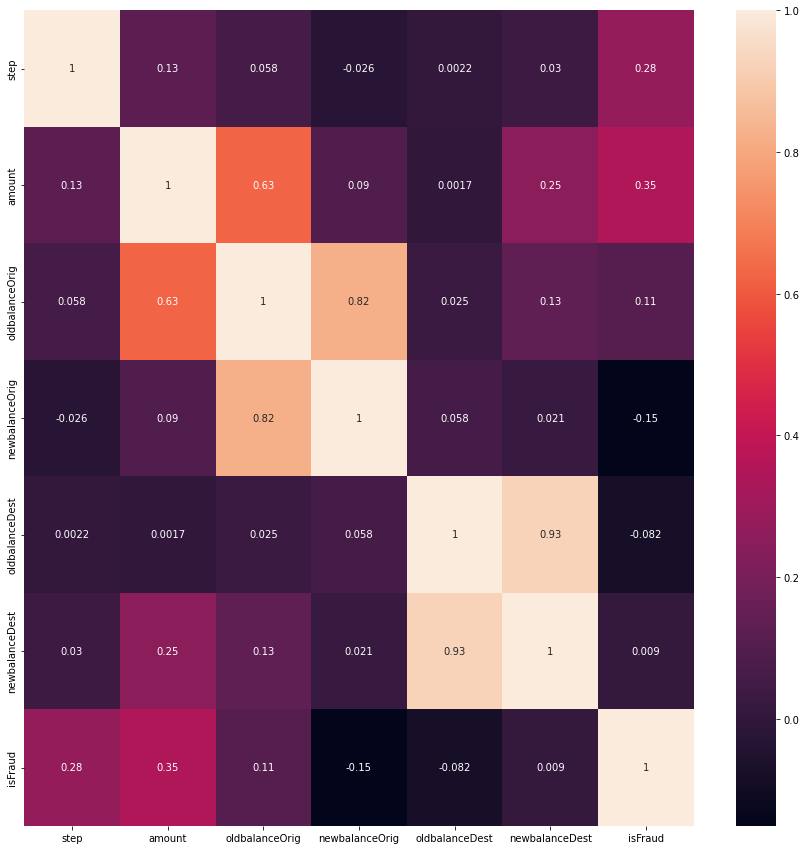

In [3]:
df = transactions.sample(frac=1)
fraud_df = df.loc[df['isFraud'] == 1]
non_fraud_df = df.loc[df['isFraud'] == 0][:len(fraud_df)]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
new_df = normal_distributed_df.sample(frac=1)

print("Distribution of the classes in the Balanced dataset")
print(new_df["isFraud"].value_counts()/len(new_df))
plt.figure(figsize=(15,15))
g = sns.heatmap(new_df.corr(), annot=True)

### Dataset Function

In [4]:
def generate_dataset(random_state):
    transactions = pd.read_csv("../data/transactions_train.csv")
    X = transactions[["type", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]
    Y = transactions["isFraud"]
    X_train, X_test_val, Y_train, Y_test_val = train_test_split(X, Y, test_size=0.2)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test_val, Y_test_val, test_size=0.5)
    
    print("y_train Fraud: {:.2f}%".format(Y_train.value_counts()[0]/len(Y_train)*100))
    print("y_train Non-fraud: {:.2f}%".format(Y_train.value_counts()[1]/len(Y_train)*100))    
    print("y_test Fraud: {:.2f}%".format(Y_test.value_counts()[0]/len(Y_test)*100))
    print("y_test Non-fraud: {:.2f}%".format(Y_test.value_counts()[1]/len(Y_test)*100))
    nb_classes = len(np.unique(Y_train))
    
    return X_train, Y_train,X_val,Y_val, X_test ,Y_test,nb_classes


### Create MLP Model

In [5]:
def create_model(n_of_features,dropout,l2,lr,random_state,nb_classes):
    print("Creating Model")
    model = Sequential()
    model.add(Dense(units=256, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout, seed=random_state))
    model.add(Dense(units=256, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout, seed=random_state))
    model.add(Dense(units=256, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout, seed=random_state))
    model.add(Dense(units=256, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout, seed=random_state))
    model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout, seed=random_state))
    model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#    model.add(Dense(units=nb_classes))
#    model.add(Activation('softmax'))
    model.add(Dense(units=1))
    model.add(Activation('relu'))
    model.compile(loss='mean_absolute_error',optimizer=Adam(lr=lr))
#    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=Adam(lr=lr))    
    model.summary()
    print("Done creating Model")
    return model;

### Train Function

In [6]:
def train(X_train, Y_train,X_val,Y_val, X_test ,Y_test,nb_classes,epochs,batch_size,patience):
    results = {
    "Accuracy": [],
    "F1-Score": [],
    "MCC": [],
    "TP": [],
    "FP": [],
    "FN": [],
    "TN": [], }
    
    print("Distribution of y_train set BEFORE balancing: {}", Counter(Y_train))
    under = RandomUnderSampler(sampling_strategy=0.002)
    X_train, Y_train = under.fit_resample(X_train, Y_train)
 
    print("Distribution of y_train set AFTER balancing: {}", Counter(Y_train))

    #encode categorical inputs  
    type_encoder = LabelEncoder()
    type_names = X_train["type"].unique()
    type_encoder.fit(type_names)
    type_encoder.classes_ = np.append(type_encoder.classes_, "<unknown>")
    
    X_train["type"] = type_encoder.transform(X_train["type"])
    X_val["type"] = type_encoder.transform(X_val["type"])
 
    # Normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
#    Y_train = to_categorical(Y_train, nb_classes)
#    Y_test = to_categorical(Y_test, nb_classes)
#    Y_test = to_categorical(Y_test, nb_classes)
    
    #to float32 for tensorflow
    X_train=np.asarray(X_train).astype(np.float32)
    X_val=np.asarray(X_val).astype(np.float32)

    print("Start Training")
    cb =[EarlyStopping(monitor='val_loss', patience=patience, verbose =1, restore_best_weights=True)]    
    history = model.fit(X_train, Y_train,validation_data=(X_val, Y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks= cb)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(trial_name+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(trial_name+'_training.png')
    print("training_complete")

    predictions = model.predict(X_val)
    f1score = f1_score(Y_val, predictions)
    accuracy = accuracy_score(Y_val, predictions)
    tn, fp, fn, tp = confusion_matrix(Y_val, predictions).ravel()
    mcc=matthews_corrcoef(Y_val, predictions)

    results["Accuracy"].append(accuracy)
    results["F1-Score"].append(mcc)
    results["MCC"].append(f1score)
    results["TP"].append(tp)
    results["FP"].append(fp)
    results["FN"].append(fn)
    results["TN"].append(tn)
          
        
    results_df = pd.DataFrame(results)
    results_df
    
    #encode categorical inputs  for test set and scale it
    type_encoder = LabelEncoder()
    type_names = X_test["type"].unique()
    type_encoder.fit(type_names)
    type_encoder.classes_ = np.append(type_encoder.classes_, "<unknown>")
    X_test["type"] = type_encoder.transform(X_test["type"])        
    
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    X_test=np.asarray(X_test).astype(np.float32)  
        

    #model test
    
    predictions = model.predict(X_test)
    
    f1score = f1_score(Y_test, predictions)
    accuracy = accuracy_score(Y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()
    mcc=matthews_corrcoef(Y_test, predictions)

    print("F1Score: {}".format(f1score))
    print("Accuracy: {}".format(accuracy))
    print("MCC: {}".format(mcc))
    
    # serialize model to JSON
    model_json = model.to_json()
    
    
    with open("../MLP_saved_models/"+trial_name+".json", "w") as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    model.save_weights("../MLP_saved_models/"+trial_name+".h5")


In [7]:
#Hyperparameters

config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0 } ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
tf.debugging.set_log_device_placement(True)

trial_name="MLP-balanced"
epochs=50
patience=10
dropout = 0.15
l2 = 0.00
lr = 0.0005
batch_size= 512

random_state = 42
os.environ['PYTHONHASHSEED'] = "42"
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [8]:
X_train, Y_train,X_val,Y_val, X_test ,Y_test,nb_classes= generate_dataset(random_state)

y_train Fraud: 99.88%
y_train Non-fraud: 0.12%
y_test Fraud: 99.87%
y_test Non-fraud: 0.13%


In [9]:
model=create_model(6,dropout,l2,lr,random_state,nb_classes)

Creating Model
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:lo

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/

In [ ]:
trained_model = train(X_train, Y_train,X_val,Y_val, X_test ,Y_test,nb_classes,epochs,batch_size,patience)

Distribution of y_train set BEFORE balancing: {} Counter({0: 5074781, 1: 6173})
Distribution of y_train set AFTER balancing: {} Counter({0: 3086500, 1: 6173})
Start Training
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op P

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:loc

Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localho

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /j

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
  37/6041 [..............................] - ETA: 1:57 - loss: 0.0296Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
  40/6041 [..............................] - ETA: 1:57 - loss: 0.0276Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
  43/6041 [..............................] - ETA: 1:57 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 103/6041 [..............................] - ETA: 1:58 - loss: 0.0120Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 106/6041 [..............................] - ETA: 1:58 - loss: 0.0117Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 109/6041 [..............................] - ETA: 1:58 - loss: 0.0114Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

 169/6041 [..............................] - ETA: 1:58 - loss: 0.0080Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 172/6041 [..............................] - ETA: 1:58 - loss: 0.0080Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 175/6041 [..............................] - ETA: 1:58 - loss: 0.0079Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 238/6041 [>.............................] - ETA: 1:57 - loss: 0.0064Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 241/6041 [>.............................] - ETA: 1:57 - loss: 0.0063Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 244/6041 [>.............................] - ETA: 1:57 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 304/6041 [>.............................] - ETA: 1:55 - loss: 0.0054Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 307/6041 [>.............................] - ETA: 1:55 - loss: 0.0054Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 310/6041 [>.............................] - ETA: 1:55 - loss: 0.0053Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

 370/6041 [>.............................] - ETA: 1:54 - loss: 0.0047Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 373/6041 [>.............................] - ETA: 1:54 - loss: 0.0047Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 376/6041 [>.............................] - ETA: 1:54 - loss: 0.0047Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 439/6041 [=>............................] - ETA: 1:52 - loss: 0.0043Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 442/6041 [=>............................] - ETA: 1:52 - loss: 0.0043Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 445/6041 [=>............................] - ETA: 1:52 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 505/6041 [=>............................] - ETA: 1:51 - loss: 0.0040Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 508/6041 [=>............................] - ETA: 1:51 - loss: 0.0040Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 511/6041 [=>............................] - ETA: 1:51 - loss: 0.0040Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

 571/6041 [=>............................] - ETA: 1:49 - loss: 0.0038Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 574/6041 [=>............................] - ETA: 1:49 - loss: 0.0038Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 577/6041 [=>............................] - ETA: 1:49 - loss: 0.0038Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 640/6041 [==>...........................] - ETA: 1:48 - loss: 0.0036Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 643/6041 [==>...........................] - ETA: 1:48 - loss: 0.0036Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 646/6041 [==>...........................] - ETA: 1:48 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 706/6041 [==>...........................] - ETA: 1:47 - loss: 0.0034Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 709/6041 [==>...........................] - ETA: 1:47 - loss: 0.0034Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 712/6041 [==>...........................] - ETA: 1:47 - loss: 0.0034Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

 772/6041 [==>...........................] - ETA: 1:45 - loss: 0.0033Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 775/6041 [==>...........................] - ETA: 1:45 - loss: 0.0033Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 778/6041 [==>...........................] - ETA: 1:45 - loss: 0.0033Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 841/6041 [===>..........................] - ETA: 1:44 - loss: 0.0032Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 844/6041 [===>..........................] - ETA: 1:44 - loss: 0.0032Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 847/6041 [===>..........................] - ETA: 1:44 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 907/6041 [===>..........................] - ETA: 1:43 - loss: 0.0032Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 910/6041 [===>..........................] - ETA: 1:43 - loss: 0.0032Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 913/6041 [===>..........................] - ETA: 1:43 - loss: 0.0032Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

 973/6041 [===>..........................] - ETA: 1:41 - loss: 0.0031Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 976/6041 [===>..........................] - ETA: 1:41 - loss: 0.0031Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 979/6041 [===>..........................] - ETA: 1:41 - loss: 0.0031Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1042/6041 [====>.........................] - ETA: 1:40 - loss: 0.0030Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1045/6041 [====>.........................] - ETA: 1:40 - loss: 0.0030Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1048/6041 [====>.........................] - ETA: 1:40 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1108/6041 [====>.........................] - ETA: 1:39 - loss: 0.0029Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1111/6041 [====>.........................] - ETA: 1:39 - loss: 0.0029Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1114/6041 [====>.........................] - ETA: 1:39 - loss: 0.0029Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

1174/6041 [====>.........................] - ETA: 1:38 - loss: 0.0029Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1177/6041 [====>.........................] - ETA: 1:37 - loss: 0.0029Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1180/6041 [====>.........................] - ETA: 1:37 - loss: 0.0029Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1243/6041 [=====>........................] - ETA: 1:36 - loss: 0.0028Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1246/6041 [=====>........................] - ETA: 1:36 - loss: 0.0028Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1249/6041 [=====>........................] - ETA: 1:36 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1309/6041 [=====>........................] - ETA: 1:35 - loss: 0.0028Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1312/6041 [=====>........................] - ETA: 1:35 - loss: 0.0028Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1315/6041 [=====>........................] - ETA: 1:35 - loss: 0.0028Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

1375/6041 [=====>........................] - ETA: 1:33 - loss: 0.0028Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1378/6041 [=====>........................] - ETA: 1:33 - loss: 0.0028Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1381/6041 [=====>........................] - ETA: 1:33 - loss: 0.0028Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1444/6041 [======>.......................] - ETA: 1:32 - loss: 0.0027Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1447/6041 [======>.......................] - ETA: 1:32 - loss: 0.0027Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1450/6041 [======>.......................] - ETA: 1:32 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1510/6041 [======>.......................] - ETA: 1:31 - loss: 0.0027Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1513/6041 [======>.......................] - ETA: 1:31 - loss: 0.0027Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1516/6041 [======>.......................] - ETA: 1:31 - loss: 0.0027Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

1576/6041 [======>.......................] - ETA: 1:29 - loss: 0.0026Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1579/6041 [======>.......................] - ETA: 1:29 - loss: 0.0026Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1582/6041 [======>.......................] - ETA: 1:29 - loss: 0.0026Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1645/6041 [=======>......................] - ETA: 1:28 - loss: 0.0026Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1648/6041 [=======>......................] - ETA: 1:28 - loss: 0.0026Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1651/6041 [=======>......................] - ETA: 1:28 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1711/6041 [=======>......................] - ETA: 1:27 - loss: 0.0026Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1714/6041 [=======>......................] - ETA: 1:27 - loss: 0.0026Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1717/6041 [=======>......................] - ETA: 1:26 - loss: 0.0026Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

1777/6041 [=======>......................] - ETA: 1:25 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1780/6041 [=======>......................] - ETA: 1:25 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1783/6041 [=======>......................] - ETA: 1:25 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1846/6041 [========>.....................] - ETA: 1:24 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1849/6041 [========>.....................] - ETA: 1:24 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1852/6041 [========>.....................] - ETA: 1:24 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1912/6041 [========>.....................] - ETA: 1:23 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1915/6041 [========>.....................] - ETA: 1:22 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1918/6041 [========>.....................] - ETA: 1:22 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

1978/6041 [========>.....................] - ETA: 1:21 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1981/6041 [========>.....................] - ETA: 1:21 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
1984/6041 [========>.....................] - ETA: 1:21 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2047/6041 [=========>....................] - ETA: 1:20 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2050/6041 [=========>....................] - ETA: 1:20 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2053/6041 [=========>....................] - ETA: 1:20 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2113/6041 [=========>....................] - ETA: 1:18 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2116/6041 [=========>....................] - ETA: 1:18 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2119/6041 [=========>....................] - ETA: 1:18 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

2179/6041 [=========>....................] - ETA: 1:17 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2182/6041 [=========>....................] - ETA: 1:17 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2185/6041 [=========>....................] - ETA: 1:17 - loss: 0.0025Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2248/6041 [==========>...................] - ETA: 1:16 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2251/6041 [==========>...................] - ETA: 1:16 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2254/6041 [==========>...................] - ETA: 1:16 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2314/6041 [==========>...................] - ETA: 1:14 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2317/6041 [==========>...................] - ETA: 1:14 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2320/6041 [==========>...................] - ETA: 1:14 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

2380/6041 [==========>...................] - ETA: 1:13 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2383/6041 [==========>...................] - ETA: 1:13 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2386/6041 [==========>...................] - ETA: 1:13 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2449/6041 [===========>..................] - ETA: 1:12 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2452/6041 [===========>..................] - ETA: 1:12 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2455/6041 [===========>..................] - ETA: 1:12 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2515/6041 [===========>..................] - ETA: 1:10 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2518/6041 [===========>..................] - ETA: 1:10 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2521/6041 [===========>..................] - ETA: 1:10 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

2581/6041 [===========>..................] - ETA: 1:09 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2584/6041 [===========>..................] - ETA: 1:09 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2587/6041 [===========>..................] - ETA: 1:09 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2650/6041 [============>.................] - ETA: 1:08 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2653/6041 [============>.................] - ETA: 1:08 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2656/6041 [============>.................] - ETA: 1:07 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2716/6041 [============>.................] - ETA: 1:06 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2719/6041 [============>.................] - ETA: 1:06 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2722/6041 [============>.................] - ETA: 1:06 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

2782/6041 [============>.................] - ETA: 1:05 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2785/6041 [============>.................] - ETA: 1:05 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2788/6041 [============>.................] - ETA: 1:05 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2851/6041 [=============>................] - ETA: 1:04 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2854/6041 [=============>................] - ETA: 1:04 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2857/6041 [=============>................] - ETA: 1:03 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2917/6041 [=============>................] - ETA: 1:02 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2920/6041 [=============>................] - ETA: 1:02 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2923/6041 [=============>................] - ETA: 1:02 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

2983/6041 [=============>................] - ETA: 1:01 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2986/6041 [=============>................] - ETA: 1:01 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
2989/6041 [=============>................] - ETA: 1:01 - loss: 0.0024Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3052/6041 [==============>...............] - ETA: 1:00 - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3055/6041 [==============>...............] - ETA: 59s - loss: 0.0023 Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3058/6041 [==============>...............] - ETA: 59s - loss: 

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3118/6041 [==============>...............] - ETA: 58s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3121/6041 [==============>...............] - ETA: 58s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3124/6041 [==============>...............] - ETA: 58s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

3184/6041 [==============>...............] - ETA: 57s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3187/6041 [==============>...............] - ETA: 57s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3190/6041 [==============>...............] - ETA: 57s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3253/6041 [===============>..............] - ETA: 55s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3256/6041 [===============>..............] - ETA: 55s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3259/6041 [===============>..............] - ETA: 55s - loss: 0.

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3319/6041 [===============>..............] - ETA: 54s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3322/6041 [===============>..............] - ETA: 54s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3325/6041 [===============>..............] - ETA: 54s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

3385/6041 [===============>..............] - ETA: 53s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3388/6041 [===============>..............] - ETA: 53s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3391/6041 [===============>..............] - ETA: 53s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3454/6041 [================>.............] - ETA: 51s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3457/6041 [================>.............] - ETA: 51s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3460/6041 [================>.............] - ETA: 51s - loss: 0.

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3520/6041 [================>.............] - ETA: 50s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3523/6041 [================>.............] - ETA: 50s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3526/6041 [================>.............] - ETA: 50s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

3586/6041 [================>.............] - ETA: 49s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3589/6041 [================>.............] - ETA: 49s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3592/6041 [================>.............] - ETA: 49s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3655/6041 [=================>............] - ETA: 47s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3658/6041 [=================>............] - ETA: 47s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3661/6041 [=================>............] - ETA: 47s - loss: 0.

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3721/6041 [=================>............] - ETA: 46s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3724/6041 [=================>............] - ETA: 46s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3727/6041 [=================>............] - ETA: 46s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

3787/6041 [=================>............] - ETA: 45s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3790/6041 [=================>............] - ETA: 45s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3793/6041 [=================>............] - ETA: 45s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3856/6041 [==================>...........] - ETA: 43s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3859/6041 [==================>...........] - ETA: 43s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3862/6041 [==================>...........] - ETA: 43s - loss: 0.

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3922/6041 [==================>...........] - ETA: 42s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3925/6041 [==================>...........] - ETA: 42s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3928/6041 [==================>...........] - ETA: 42s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

3988/6041 [==================>...........] - ETA: 41s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3991/6041 [==================>...........] - ETA: 41s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
3994/6041 [==================>...........] - ETA: 41s - loss: 0.0023Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4057/6041 [===================>..........] - ETA: 39s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4060/6041 [===================>..........] - ETA: 39s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4063/6041 [===================>..........] - ETA: 39s - loss: 0.

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4123/6041 [===================>..........] - ETA: 38s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4126/6041 [===================>..........] - ETA: 38s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4129/6041 [===================>..........] - ETA: 38s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

4189/6041 [===================>..........] - ETA: 37s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4192/6041 [===================>..........] - ETA: 37s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4195/6041 [===================>..........] - ETA: 37s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4257/6041 [====================>.........] - ETA: 35s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4260/6041 [====================>.........] - ETA: 35s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4263/6041 [====================>.........] - ETA: 35s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

4323/6041 [====================>.........] - ETA: 34s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4326/6041 [====================>.........] - ETA: 34s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4329/6041 [====================>.........] - ETA: 34s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4391/6041 [====================>.........] - ETA: 33s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4394/6041 [====================>.........] - ETA: 33s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4397/6041 [====================>.........] - ETA: 33s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

4457/6041 [=====================>........] - ETA: 31s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4460/6041 [=====================>........] - ETA: 31s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4463/6041 [=====================>........] - ETA: 31s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

4522/6041 [=====================>........] - ETA: 30s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4525/6041 [=====================>........] - ETA: 30s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4528/6041 [=====================>........] - ETA: 30s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4591/6041 [=====================>........] - ETA: 29s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4594/6041 [=====================>........] - ETA: 29s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4596/6041 [=====================>........] - ETA: 29s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

4656/6041 [======================>.......] - ETA: 28s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4659/6041 [======================>.......] - ETA: 27s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4662/6041 [======================>.......] - ETA: 27s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4725/6041 [======================>.......] - ETA: 26s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4728/6041 [======================>.......] - ETA: 26s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4731/6041 [======================>.......] - ETA: 26s - loss: 0.

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4791/6041 [======================>.......] - ETA: 25s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4794/6041 [======================>.......] - ETA: 25s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4797/6041 [======================>.......] - ETA: 25s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

4857/6041 [=======================>......] - ETA: 23s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4860/6041 [=======================>......] - ETA: 23s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4863/6041 [=======================>......] - ETA: 23s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4926/6041 [=======================>......] - ETA: 22s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4929/6041 [=======================>......] - ETA: 22s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4932/6041 [=======================>......] - ETA: 22s - loss: 0.

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4992/6041 [=======================>......] - ETA: 21s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4995/6041 [=======================>......] - ETA: 21s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
4998/6041 [=======================>......] - ETA: 21s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

5058/6041 [========================>.....] - ETA: 19s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5061/6041 [========================>.....] - ETA: 19s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5064/6041 [========================>.....] - ETA: 19s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5127/6041 [========================>.....] - ETA: 18s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5130/6041 [========================>.....] - ETA: 18s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5133/6041 [========================>.....] - ETA: 18s - loss: 0.

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5193/6041 [========================>.....] - ETA: 17s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5196/6041 [========================>.....] - ETA: 17s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5199/6041 [========================>.....] - ETA: 17s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

5259/6041 [=========================>....] - ETA: 15s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5262/6041 [=========================>....] - ETA: 15s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5265/6041 [=========================>....] - ETA: 15s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5327/6041 [=========================>....] - ETA: 14s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5330/6041 [=========================>....] - ETA: 14s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5333/6041 [=========================>....] - ETA: 14s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

5393/6041 [=========================>....] - ETA: 13s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5396/6041 [=========================>....] - ETA: 13s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5399/6041 [=========================>....] - ETA: 12s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5462/6041 [==========================>...] - ETA: 11s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5465/6041 [==========================>...] - ETA: 11s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5468/6041 [==========================>...] - ETA: 11s - loss: 0.

5527/6041 [==========================>...] - ETA: 10s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5530/6041 [==========================>...] - ETA: 10s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5533/6041 [==========================>...] - ETA: 10s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CP

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5596/6041 [==========================>...] - ETA: 9s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5599/6041 [==========================>...] - ETA: 8s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5602/6041 [==========================>...] - ETA: 8s - loss: 0.002

5662/6041 [===========================>..] - ETA: 7s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5665/6041 [===========================>..] - ETA: 7s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5668/6041 [===========================>..] - ETA: 7s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0

5729/6041 [===========================>..] - ETA: 6s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5732/6041 [===========================>..] - ETA: 6s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5735/6041 [===========================>..] - ETA: 6s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5798/6041 [===========================>..] - ETA: 4s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5801/6041 [===========================>..] - ETA: 4s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5804/6041 [===========================>..] - ETA: 4s - loss: 0.002

5863/6041 [============================>.] - ETA: 3s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5866/6041 [============================>.] - ETA: 3s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5869/6041 [============================>.] - ETA: 3s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5932/6041 [============================>.] - ETA: 2s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5935/6041 [============================>.] - ETA: 2s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
5938/6041 [============================>.] - ETA: 2s - loss: 0.002

5998/6041 [============================>.] - ETA: 0s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
6001/6041 [============================>.] - ETA: 0s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
6004/6041 [============================>.] - ETA: 0s - loss: 0.0022Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_test_function_9651 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:loc

  29/6041 [..............................] - ETA: 2:09 - loss: 0.0018Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
  32/6041 [..............................] - ETA: 2:10 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
  35/6041 [..............................] - ETA: 2:11 - loss: 0.0018Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
  96/6041 [..............................] - ETA: 2:18 - loss: 0.0018Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
  99/6041 [..............................] - ETA: 2:18 - loss: 0.0018Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 102/6041 [..............................] - ETA: 2:18 - loss:

 159/6041 [..............................] - ETA: 2:21 - loss: 0.0020Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 162/6041 [..............................] - ETA: 2:21 - loss: 0.0020Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 165/6041 [..............................] - ETA: 2:21 - loss: 0.0020Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

 224/6041 [>.............................] - ETA: 2:21 - loss: 0.0020Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 227/6041 [>.............................] - ETA: 2:21 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 230/6041 [>.............................] - ETA: 2:20 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 292/6041 [>.............................] - ETA: 2:16 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 295/6041 [>.............................] - ETA: 2:16 - loss: 0.0020Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 297/6041 [>.............................] - ETA: 2:16 - loss: 0.0020Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

 356/6041 [>.............................] - ETA: 2:13 - loss: 0.0020Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 359/6041 [>.............................] - ETA: 2:13 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 362/6041 [>.............................] - ETA: 2:13 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 425/6041 [=>............................] - ETA: 2:09 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 428/6041 [=>............................] - ETA: 2:09 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 431/6041 [=>............................] - ETA: 2:08 - loss:

Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 491/6041 [=>............................] - ETA: 2:05 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 494/6041 [=>............................] - ETA: 2:05 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 497/6041 [=>............................] - ETA: 2:05 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device

 557/6041 [=>............................] - ETA: 2:02 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 560/6041 [=>............................] - ETA: 2:02 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
 563/6041 [=>............................] - ETA: 2:01 - loss: 0.0019Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_train_function_3315 in device /job:localhost/replica:0/task:0/device